In [4]:
import os
import time
import glob
import pickle
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import MultipleLocator, MaxNLocator, FormatStrFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
from numpy.ma import masked_array
import numpy as np
import xarray as xr
import cartopy.crs as crs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from wrf import (LambertConformal, get_proj_params, to_np, getvar, destagger, ll_to_xy, smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim, latlon_coords, interplevel, xy, ALL_TIMES)
from shapely.geometry import MultiPolygon, Polygon
from datetime import datetime, timezone
from scipy.ndimage import uniform_filter1d
from scipy.signal import windows as win
from scipy.stats import moment
import scipy.stats as stats
from scipy import signal
from pyproj import Geod
from adjustText import adjust_text
from matplotlib import patheffects
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
from concurrent.futures import ProcessPoolExecutor, as_completed
from numpy.lib.stride_tricks import sliding_window_view
import multiprocessing as mp
import pandas as pd
import threading
import datetime
import psutil
import math
import pytz

# Add the LaTeX bin path to the environment
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.serif": ["Computer Modern Roman"]})


In [11]:
# Enter the data folder:
os.chdir("../data")

# Get the available data files for Block Island:
BLOC_files = sorted(glob.glob("bloc.*"))

# Get the available data files for Martha's vineyard:
MVCO_files = sorted(glob.glob("mvco.*"))

# Get the available data files for Nantucket:
NANT_files = sorted(glob.glob("nant.*"))

# Define the hub height in meters for IEA 3.4-MW WT:
z_hub = 110


In [12]:
###############
# Block Island
###############

# Initialize lists to save results:
all_t_BLOC       = []
all_z_BLOC       = []
all_WS_BLOC      = []
all_WD_BLOC      = []
all_maxWS_BLOC   = []
all_z_maxWS_BLOC = []
all_WS_hub_BLOC  = []
all_WD_hub_BLOC  = []

for BLOC_file in BLOC_files:
    with Dataset(BLOC_file, mode='r') as nc:
        # Extract the raw time:
        t_raw = nc.variables['time'][:]  
        # Extract the corresponding time: 
        t_units = nc.variables['time'].units
        # Extract the corresponding calendar:
        t_calendar = nc.variables['time'].calendar  
        # Convert to Python datetime objects:
        t_dt = num2date(t_raw, units=t_units, calendar=t_calendar)
        # Convert to numeric date format:
        t_BLOC = mdates.date2num(t_dt)

        # Extract the height above ground level:
        z_BLOC = nc.variables["height"][:]

        # Extract the wind speed:
        WS_BLOC = np.transpose(np.ma.filled(nc.variables["Vhm"][:], np.nan))
        # Extract the maximum 1-sec wind speed over height with respect to time:
        #maxWS_BLOC = np.nanmax(WS_BLOC, axis=0)
        maxWS_BLOC = np.nanmax(np.transpose(np.ma.filled(nc.variables["VhMax"][:], np.nan)), axis=0)
        # Get the corresponding height at which the maximum occurs:
        idx_z_maxWS_BLOC = np.nanargmax(WS_BLOC, axis=0)  
        z_maxWS_BLOC     = z_BLOC[idx_z_maxWS_BLOC]  

        # Extract the wind direction:
        WD_BLOC = np.transpose(np.ma.filled(nc.variables["Azim"][:], np.nan))

        if z_hub in z_BLOC:
            # Extract the wind speed at the defined hub height, if available:
            idx         = np.where(z_BLOC == z_hub)[0][0]
            WS_hub_BLOC = WS_BLOC[idx, :]  
            WD_hub_BLOC = WS_BLOC[idx, :]
        else:
            # If not, interpolate vertically:
            WS_hub_BLOC = np.array([np.interp(z_hub, z_BLOC, WS_BLOC[:, i]) for i in range(WS_BLOC.shape[1])])
            WD_hub_BLOC = np.array([np.interp(z_hub, z_BLOC, WD_BLOC[:, i]) for i in range(WD_BLOC.shape[1])])

        # Store the results:
        all_t_BLOC.append(t_BLOC)
        all_z_BLOC.append(z_BLOC)
        all_WS_BLOC.append(WS_BLOC)
        all_WD_BLOC.append(WD_BLOC)
        all_maxWS_BLOC.append(maxWS_BLOC)
        all_z_maxWS_BLOC.append(z_maxWS_BLOC)
        all_WS_hub_BLOC.append(WS_hub_BLOC)
        all_WD_hub_BLOC.append(WD_hub_BLOC)

all_t_BLOC       = np.concatenate(all_t_BLOC)
all_z_BLOC       = np.unique(np.concatenate(all_z_BLOC))   
all_WS_BLOC      = np.concatenate(all_WS_BLOC, axis=1)
all_WD_BLOC      = np.concatenate(all_WD_BLOC, axis=1)
all_maxWS_BLOC   = np.concatenate(all_maxWS_BLOC)
all_z_maxWS_BLOC = np.concatenate(all_z_maxWS_BLOC)
all_WS_hub_BLOC  = np.concatenate(all_WS_hub_BLOC)
all_WD_hub_BLOC  = np.concatenate(all_WD_hub_BLOC)

# Extract the location of the instrument:
lat_BLOC = Dataset(BLOC_file, mode='r').variables["lat"][:]
lon_BLOC = Dataset(BLOC_file, mode='r').variables["lon"][:]


In [4]:
####################
# Martha's vineyard
####################

# Initialize lists to save results:
all_t_MVCO       = []
all_z_MVCO       = []
all_WS_MVCO      = []
all_WD_MVCO      = []
all_maxWS_MVCO   = []
all_z_maxWS_MVCO = []
all_WS_hub_MVCO  = []
all_WD_hub_MVCO  = []

for MVCO_file in MVCO_files:
    with Dataset(MVCO_file, mode='r') as nc:
        # Extract the raw time:
        t_raw = nc.variables['time'][:]  
        # Extract the corresponding time: 
        t_units = nc.variables['time'].units
        # Extract the corresponding calendar:
        t_calendar = nc.variables['time'].calendar  
        # Convert to Python datetime objects:
        t_dt = num2date(t_raw, units=t_units, calendar=t_calendar)
        # Convert to numeric date format:
        t_MVCO = mdates.date2num(t_dt)

        # Extract the height above ground level:
        z_MVCO = nc.variables["height"][:]

        # Extract the wind speed:
        WS_MVCO = np.transpose(np.ma.filled(nc.variables["Vhm"][:], np.nan))
        # Extract the maximum 1-sec wind speed:
        maxWS_2D_MVCO = np.transpose(np.ma.filled(nc.variables["VhMax"][:], np.nan))
        # Extract the height corresponding to maximum wind speed:
        m                                = np.ma.masked_invalid(maxWS_2D_MVCO)
        maxWS_MVCO                       = m.max(axis=0).filled(np.nan)   
        idx                              = m.argmax(axis=0)                
        z_maxWS_MVCO                     = z_MVCO[idx].astype(float)      
        z_maxWS_MVCO[m.mask.all(axis=0)] = np.nan   

        # Extract the wind direction:
        WD_MVCO = np.transpose(np.ma.filled(nc.variables["Azim"][:], np.nan))
        
        if z_hub in z_MVCO:
            # Extract the wind speed at the defined hub height, if available:
            idx         = np.where(z_MVCO == z_hub)[0][0]
            WS_hub_MVCO = WS_MVCO[idx, :]  
            WD_hub_MVCO = WD_MVCO[idx, :]
        else:
            # If not, interpolate vertically:
            WS_hub_MVCO  = np.array([np.interp(z_hub, z_MVCO, WS_MVCO[:, i]) for i in range(WS_MVCO.shape[1])])
            WD_hub_MVCO  = np.array([np.interp(z_hub, z_MVCO, WD_MVCO[:, i]) for i in range(WD_MVCO.shape[1])])

        # Store the results:
        all_t_MVCO.append(t_MVCO)
        all_z_MVCO.append(z_MVCO)
        all_WS_MVCO.append(WS_MVCO)
        all_WD_MVCO.append(WD_MVCO)
        all_maxWS_MVCO.append(maxWS_MVCO)
        all_z_maxWS_MVCO.append(z_maxWS_MVCO)
        all_WS_hub_MVCO.append(WS_hub_MVCO)
        all_WD_hub_MVCO.append(WD_hub_MVCO)
        
all_t_MVCO       = np.concatenate(all_t_MVCO)
all_z_MVCO       = np.unique(np.concatenate(all_z_MVCO))   
all_WS_MVCO      = np.concatenate(all_WS_MVCO, axis=1)
all_WD_MVCO      = np.concatenate(all_WD_MVCO, axis=1)
all_maxWS_MVCO   = np.concatenate(all_maxWS_MVCO)
all_z_maxWS_MVCO = np.concatenate(all_z_maxWS_MVCO)
all_WS_hub_MVCO  = np.concatenate(all_WS_hub_MVCO)
all_WD_hub_MVCO  = np.concatenate(all_WD_hub_MVCO)

# Extract the location of the instrument:
lat_MVCO = Dataset(MVCO_file, mode='r').variables["lat"][:]
lon_MVCO = Dataset(MVCO_file, mode='r').variables["lon"][:]


In [5]:
############
# Nantucket
############

# Initialize lists to save results:
all_t_NANT        = []
all_z_NANT        = []
all_WS_NANT       = []
all_WD_NANT       = []
all_maxWS_NANT    = []
all_z_maxWS_NANT  = []
all_WS_hub_NANT   = []
all_WD_hub_NANT   = []

for NANT_file in NANT_files:
    with Dataset(NANT_file, mode='r') as nc:
        # Extract the base time:
        t_base = nc.variables["base_time"][:]
        # Extract the offset time:
        t_offset = nc.variables["time_offset"][:]
        # Compute the full time:
        t_full = t_base+t_offset 
        # Compute time to have same format as the previous datasets:
        t_dt   = num2date(t_full, units="seconds since 1970-01-01 00:00:00", calendar="standard")
        t_NANT = mdates.date2num(t_dt)
        
        # Extract the height above ground level:
        z_NANT = nc.variables["height"][:]

        # Extract the wind speed:
        WS_NANT = np.ma.filled(nc.variables["wspd"][:], np.nan)
        # Extract the maximum wind speed over height with respect to time and the corresponding height:
        m                                = np.ma.masked_invalid(WS_NANT)
        maxWS_NANT                       = m.max(axis=0).filled(np.nan)
        idx                              = m.argmax(axis=0)
        z_maxWS_NANT                     = z_NANT[idx].astype(float)
        z_maxWS_NANT[m.mask.all(axis=0)] = np.nan

        # Extract the wind direction: 
        WD_NANT = np.ma.filled(nc.variables["wdir"][:], np.nan)
        
        if z_hub in z_NANT:
            # Extract the wind speed at the defined hub height, if available:
            idx          = np.where(z_NANT == z_hub)[0][0]
            WS_NANT_hub  = WS_NANT[idx, :]  
            WD_NANT_hub  = WD_NANT[idx, :] 
        else:
            # If not, interpolate vertically:
            WS_hub_NANT  = np.array([np.interp(z_hub, z_NANT, WS_NANT[:, i]) for i in range(WS_NANT.shape[1])])
            WD_hub_NANT  = np.array([np.interp(z_hub, z_NANT, WD_NANT[:, i]) for i in range(WD_NANT.shape[1])])
        
        # Store the results:
        all_t_NANT.append(t_NANT)
        all_z_NANT.append(z_NANT)
        all_WS_NANT.append(WS_NANT)
        all_WD_NANT.append(WD_NANT)
        all_maxWS_NANT.append(maxWS_NANT)
        all_z_maxWS_NANT.append(z_maxWS_NANT)
        all_WS_hub_NANT.append(WS_hub_NANT)
        all_WD_hub_NANT.append(WD_hub_NANT)

all_t_NANT       = np.concatenate(all_t_NANT)
all_z_NANT       = np.unique(np.concatenate(all_z_NANT))   
all_WS_NANT      = np.concatenate(all_WS_NANT, axis=1)
all_WD_NANT      = np.concatenate(all_WD_NANT, axis=1)
all_maxWS_NANT   = np.concatenate(all_maxWS_NANT)
all_z_maxWS_NANT = np.concatenate(all_z_maxWS_NANT)
all_WS_hub_NANT  = np.concatenate(all_WS_hub_NANT)
all_WD_hub_NANT  = np.concatenate(all_WD_hub_NANT)

# Extract the location of the instrument:
lat_NANT = Dataset(NANT_file, mode='r').variables["lat"][:]
lon_NANT = Dataset(NANT_file, mode='r').variables["lon"][:]


In [6]:
print(f"Latitude of BLOC:   {lat_BLOC}")
print(f"Longitude of BLOC: {lon_BLOC}")
print()

print(f"Latitude of MVCO:   {lat_MVCO}")
print(f"Longitude of MVCO: {lon_MVCO}")
print()

print(f"Latitude of NANT:   {lat_NANT}")
print(f"Longitude of NANT: {lon_NANT}")
print()


Latitude of BLOC:   41.166625
Longitude of BLOC: -71.580333

Latitude of MVCO:   41.361977
Longitude of MVCO: -70.522499

Latitude of NANT:   41.24255
Longitude of NANT: -70.107003



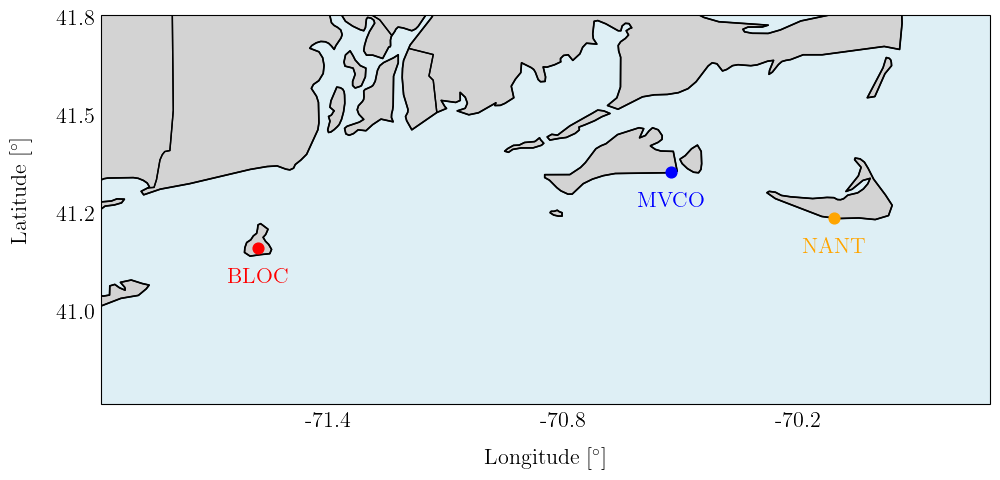

In [7]:
site_lats = np.array([lat_BLOC, lat_MVCO, lat_NANT])
site_lons = np.array([lon_BLOC, lon_MVCO, lon_NANT])

pad_lat = 0.4
pad_lon = 0.4

proj = crs.PlateCarree()

fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": proj})

ax.set_extent(
    [site_lons.min()-pad_lon, site_lons.max()+pad_lon,
     site_lats.min()-pad_lat, site_lats.max()+pad_lat],
    crs=crs.PlateCarree())

# Background features
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=0)
ax.add_feature(cfeature.OCEAN, facecolor="lightblue", alpha=0.4, zorder=0)
ax.coastlines("10m", linewidth=1.2)
ax.add_feature(cfeature.STATES.with_scale("10m"),  linewidth=1.0, edgecolor="k")
ax.add_feature(cfeature.BORDERS.with_scale("10m"), linewidth=1.2, edgecolor="magenta")

#ax.set_title("Site Locations", fontsize=16, pad=8)

gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.0, color="grey", alpha=0.3, linestyle="dashdot")

gl.top_labels   = False
gl.right_labels = False

gl.xlocator = MaxNLocator(nbins=4)
gl.ylocator = MaxNLocator(nbins=4)

# Numeric-only tick labels (no °)
gl.xformatter = FormatStrFormatter("%.1f")
gl.yformatter = FormatStrFormatter("%.1f")

# No 'pad' here – just size/rotation
gl.xlabel_style = {"size":16, "rotation":0}
gl.ylabel_style = {"size":16, "rotation":0}

# Axis labels with degree symbol
ax.text(0.5,  -0.14, r"Longitude [$^\circ$]", transform=ax.transAxes, ha="center", va="center", fontsize=16)
ax.text(-0.09, 0.55,  r"Latitude [$^\circ$]",  transform=ax.transAxes, ha="center", va="center", rotation="vertical", fontsize=16)

# Scatter points
ax.scatter(lon_BLOC, lat_BLOC, s=60, c="red",    marker="o", zorder=5, transform=crs.PlateCarree())
ax.scatter(lon_MVCO, lat_MVCO, s=60, c="blue",   marker="o", zorder=5, transform=crs.PlateCarree())
ax.scatter(lon_NANT, lat_NANT, s=60, c="orange", marker="o", zorder=5, transform=crs.PlateCarree())

# Text labels BELOW the points
ax.text(lon_BLOC, lat_BLOC-0.05, "BLOC",  transform=crs.PlateCarree(), ha="center", va="top", fontsize=16, color="red")
ax.text(lon_MVCO, lat_MVCO-0.05, "MVCO",  transform=crs.PlateCarree(), ha="center", va="top", fontsize=16, color="blue")
ax.text(lon_NANT, lat_NANT-0.05, "NANT",  transform=crs.PlateCarree(), ha="center", va="top", fontsize=16, color="orange")

fig.savefig("WFIP3_site_locations.png", dpi=600, bbox_inches="tight")

plt.tight_layout()
plt.show()


In [8]:
# Extract the height of each histogram bar and 
PDF_WS_BLOC,      binEdges_WS_BLOC      = np.histogram(WS_BLOC[~np.isnan(WS_BLOC)],               bins='auto', density=True)
PDF_WS_MVCO,      binEdges_WS_MVCO      = np.histogram(WS_MVCO[~np.isnan(WS_MVCO)],               bins='auto', density=True)
PDF_WS_NANT,      binEdges_WS_NANT      = np.histogram(WS_NANT[~np.isnan(WS_NANT)],               bins='auto', density=True)
PDF_WS_hub_BLOC,  binEdges_WS_hub_BLOC  = np.histogram(WS_hub_BLOC[~np.isnan(WS_hub_BLOC)],       bins='auto', density=True)
PDF_WS_hub_MVCO,  binEdges_WS_hub_MVCO  = np.histogram(WS_hub_MVCO[~np.isnan(WS_hub_MVCO)],       bins='auto', density=True)
PDF_WS_hub_NANT,  binEdges_WS_hub_NANT  = np.histogram(WS_hub_NANT[~np.isnan(WS_hub_NANT)],       bins='auto', density=True)
PDF_maxWS_BLOC,   binEdges_maxWS_BLOC   = np.histogram(all_maxWS_BLOC[~np.isnan(all_maxWS_BLOC)], bins='auto', density=True)
PDF_maxWS_MVCO,   binEdges_maxWS_MVCO   = np.histogram(all_maxWS_MVCO[~np.isnan(all_maxWS_MVCO)], bins='auto', density=True)
PDF_maxWS_NANT,   binEdges_maxWS_NANT   = np.histogram(all_maxWS_NANT[~np.isnan(all_maxWS_NANT)], bins='auto', density=True)
PDF_z_maxWS_BLOC, binEdges_z_maxWS_BLOC = np.histogram(all_z_maxWS_BLOC,                          bins=z_BLOC, density=True)
PDF_z_maxWS_MVCO, binEdges_z_maxWS_MVCO = np.histogram(all_z_maxWS_MVCO,                          bins=z_MVCO, density=True)
PDF_z_maxWS_NANT, binEdges_z_maxWS_NANT = np.histogram(all_z_maxWS_NANT,                          bins=z_NANT, density=True)

# Get the index of maximum PDF:
index_maxPDF_WS_BLOC      = np.argmax(PDF_WS_BLOC)
index_maxPDF_WS_MVCO      = np.argmax(PDF_WS_MVCO)
index_maxPDF_WS_NANT      = np.argmax(PDF_WS_NANT)
index_maxPDF_WS_hub_BLOC  = np.argmax(PDF_WS_hub_BLOC)
index_maxPDF_WS_hub_MVCO  = np.argmax(PDF_WS_hub_MVCO)
index_maxPDF_WS_hub_NANT  = np.argmax(PDF_WS_hub_NANT)
index_maxPDF_maxWS_BLOC   = np.argmax(PDF_maxWS_BLOC)
index_maxPDF_maxWS_MVCO   = np.argmax(PDF_maxWS_MVCO)
index_maxPDF_maxWS_NANT   = np.argmax(PDF_maxWS_NANT)
index_maxPDF_z_maxWS_BLOC = np.argmax(PDF_z_maxWS_BLOC)
index_maxPDF_z_maxWS_MVCO = np.argmax(PDF_z_maxWS_MVCO)
index_maxPDF_z_maxWS_NANT = np.argmax(PDF_z_maxWS_NANT)

# Get the bin centers:
binCenters_WS_BLOC      = 0.5 * (binEdges_WS_BLOC[1:]+binEdges_WS_BLOC[:-1])
binCenters_WS_MVCO      = 0.5 * (binEdges_WS_MVCO[1:]+binEdges_WS_MVCO[:-1])
binCenters_WS_NANT      = 0.5 * (binEdges_WS_NANT[1:]+binEdges_WS_NANT[:-1])
binCenters_WS_hub_BLOC  = 0.5 * (binEdges_WS_hub_BLOC[1:]+binEdges_WS_hub_BLOC[:-1])
binCenters_WS_hub_MVCO  = 0.5 * (binEdges_WS_hub_MVCO[1:]+binEdges_WS_hub_MVCO[:-1])
binCenters_WS_hub_NANT  = 0.5 * (binEdges_WS_hub_NANT[1:]+binEdges_WS_hub_NANT[:-1])
binCenters_maxWS_BLOC   = 0.5 * (binEdges_maxWS_BLOC[1:]+binEdges_maxWS_BLOC[:-1])
binCenters_maxWS_MVCO   = 0.5 * (binEdges_maxWS_MVCO[1:]+binEdges_maxWS_MVCO[:-1])
binCenters_maxWS_NANT   = 0.5 * (binEdges_maxWS_NANT[1:]+binEdges_maxWS_NANT[:-1])
binCenters_z_maxWS_BLOC = 0.5 * (binEdges_z_maxWS_BLOC[1:]+binEdges_z_maxWS_BLOC[:-1])
binCenters_z_maxWS_MVCO = 0.5 * (binEdges_z_maxWS_MVCO[1:]+binEdges_z_maxWS_MVCO[:-1])
binCenters_z_maxWS_NANT = 0.5 * (binEdges_z_maxWS_NANT[1:]+binEdges_z_maxWS_NANT[:-1])

# Get the bin center at maximum PDF:
maxPDF_binCenters_WS_BLOC      = binCenters_WS_BLOC[index_maxPDF_WS_BLOC]
maxPDF_binCenters_WS_MVCO      = binCenters_WS_MVCO[index_maxPDF_WS_MVCO]
maxPDF_binCenters_WS_NANT      = binCenters_WS_NANT[index_maxPDF_WS_NANT]
maxPDF_binCenters_WS_hub_BLOC  = binCenters_WS_hub_BLOC[index_maxPDF_WS_hub_BLOC]
maxPDF_binCenters_WS_hub_MVCO  = binCenters_WS_hub_MVCO[index_maxPDF_WS_hub_MVCO]
maxPDF_binCenters_WS_hub_NANT  = binCenters_WS_hub_NANT[index_maxPDF_WS_hub_NANT]
maxPDF_binCenters_maxWS_BLOC   = binCenters_maxWS_BLOC[index_maxPDF_maxWS_BLOC]
maxPDF_binCenters_maxWS_MVCO   = binCenters_maxWS_MVCO[index_maxPDF_maxWS_MVCO]
maxPDF_binCenters_maxWS_NANT   = binCenters_maxWS_NANT[index_maxPDF_maxWS_NANT]
maxPDF_binCenters_z_maxWS_BLOC = binCenters_z_maxWS_BLOC[index_maxPDF_z_maxWS_BLOC]
maxPDF_binCenters_z_maxWS_MVCO = binCenters_z_maxWS_MVCO[index_maxPDF_z_maxWS_MVCO]
maxPDF_binCenters_z_maxWS_NANT = binCenters_z_maxWS_NANT[index_maxPDF_z_maxWS_NANT]


In [38]:
print(f"(BLOC) Wind speed corresponding to maximum PDF: {maxPDF_binCenters_WS_BLOC:.1f} m/s")
print(f"(MVCO) Wind speed corresponding to maximum PDF: {maxPDF_binCenters_WS_MVCO:.1f} m/s")
print(f"(NANT) Wind speed corresponding to maximum PDF: {maxPDF_binCenters_WS_NANT:.1f} m/s")
print()


(BLOC) Wind speed corresponding to maximum PDF: 8.2 m/s
(MVCO) Wind speed corresponding to maximum PDF: 11.8 m/s
(NANT) Wind speed corresponding to maximum PDF: 12.3 m/s



In [11]:
# Define the relevant speeds for the IEA 3.4-MW WT:
cut_in  = 4
rated   = 9.8
cut_out = 25


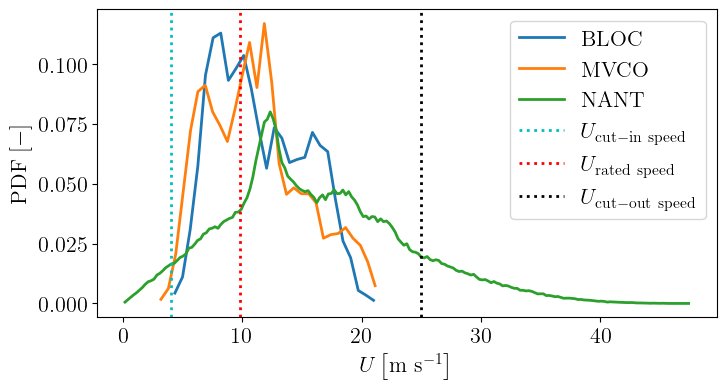

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(binCenters_WS_BLOC, PDF_WS_BLOC, lw=2, label="BLOC")
plt.plot(binCenters_WS_MVCO, PDF_WS_MVCO, lw=2, label="MVCO")
plt.plot(binCenters_WS_NANT, PDF_WS_NANT, lw=2, label="NANT")
plt.axvline(cut_in, lw=2, ls=':', color='c', label=r"$U_{\mathrm{cut-in\ speed}}$")
plt.axvline(rated, lw=2, ls=':', color='r', label=r"$U_{\mathrm{rated\ speed}}$")
plt.axvline(cut_out, lw=2, ls=':', color='k', label=r"$U_{\mathrm{cut-out\ speed}}$")
plt.xlabel(r'$U \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
plt.ylabel(r'PDF $\left[-\right]$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.savefig("PDF_WS.png", dpi=600, bbox_inches="tight")
plt.show()


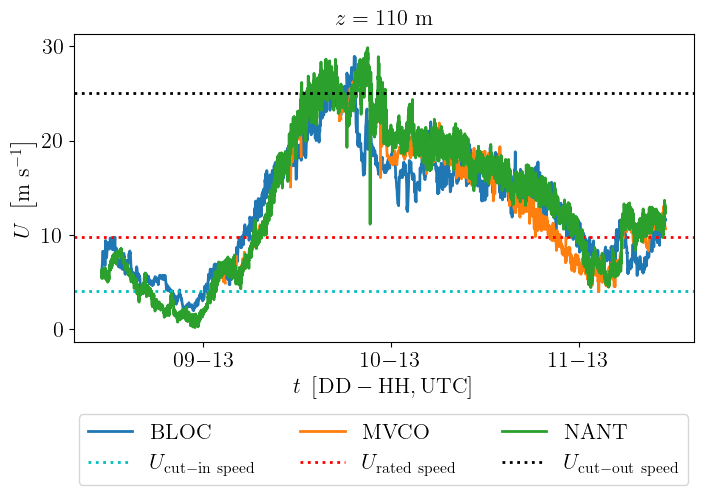

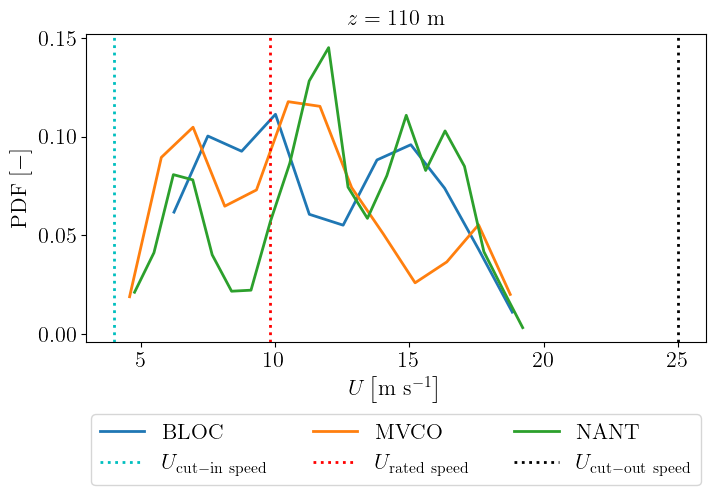

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(all_t_BLOC, all_WS_hub_BLOC, linewidth=2, label="BLOC")
plt.axhline(cut_in, lw=2, ls=':', color='c', label=r"$U_{\mathrm{cut-in\ speed}}$")
plt.plot(all_t_MVCO, all_WS_hub_MVCO, linewidth=2, label="MVCO")
plt.axhline(rated, lw=2, ls=':', color='r', label=r"$U_{\mathrm{rated\ speed}}$")
plt.plot(all_t_NANT, all_WS_hub_NANT, linewidth=2, label="NANT")
plt.axhline(cut_out, lw=2, ls=':', color='k', label=r"$U_{\mathrm{cut-out\ speed}}$")
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))            
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))        
plt.xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
plt.ylabel(r'$U\ \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
plt.title(rf'$z = {z_hub}\ \mathrm{{m}}$', fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3, frameon=True, fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.savefig("WS_hub.png", dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(binCenters_WS_hub_BLOC, PDF_WS_hub_BLOC, lw=2, label="BLOC")
plt.axvline(cut_in, lw=2, ls=':', color='c', label=r"$U_{\mathrm{cut-in\ speed}}$")
plt.plot(binCenters_WS_hub_MVCO, PDF_WS_hub_MVCO, lw=2, label="MVCO")
plt.axvline(rated, lw=2, ls=':', color='r', label=r"$U_{\mathrm{rated\ speed}}$")
plt.plot(binCenters_WS_hub_NANT, PDF_WS_hub_NANT, lw=2, label="NANT")
plt.axvline(cut_out, lw=2, ls=':', color='k', label=r"$U_{\mathrm{cut-out\ speed}}$")
plt.xlabel(r'$U \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
plt.ylabel(r'PDF $\left[-\right]$', fontsize=16)
plt.title(rf'$z = {z_hub}\ \mathrm{{m}}$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3, frameon=True, fontsize=16)
plt.savefig("PDF_WS_hub.png", dpi=600, bbox_inches="tight")
plt.show()


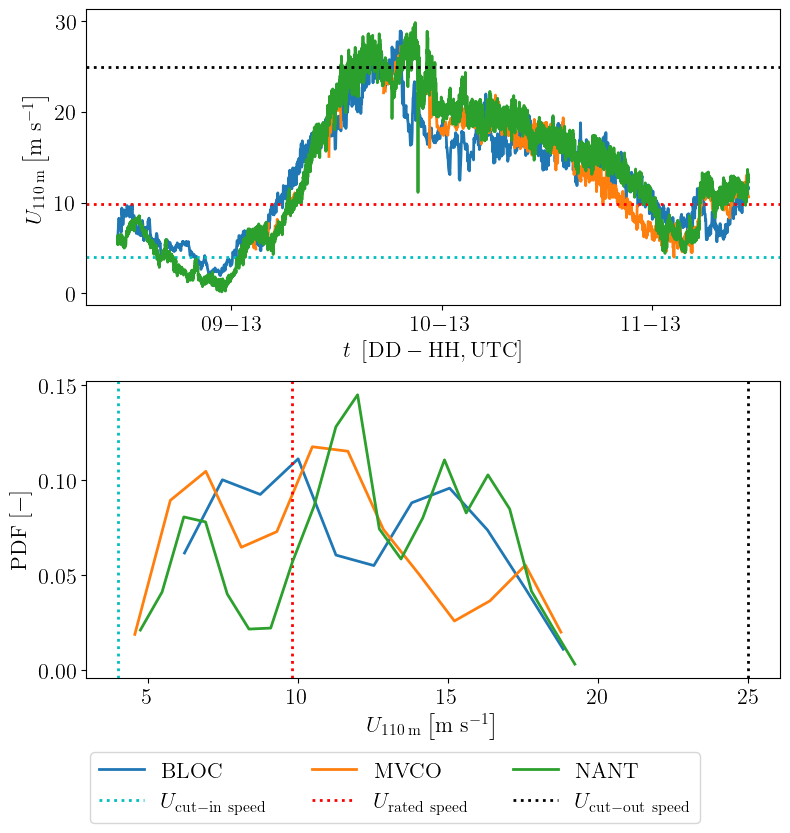

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=False)

# =======================
# (a) Time series
# =======================
axs[0].plot(all_t_BLOC, all_WS_hub_BLOC, lw=2, label="BLOC")
axs[0].axhline(cut_in,  lw=2, ls=':', color='c', label=r"$U_{\mathrm{cut-in\ speed}}$")

axs[0].plot(all_t_MVCO,  all_WS_hub_MVCO, lw=2, label="MVCO")
axs[0].axhline(rated,   lw=2, ls=':', color='r', label=r"$U_{\mathrm{rated\ speed}}$")

axs[0].plot(all_t_NANT,  all_WS_hub_NANT, lw=2, label="NANT")
axs[0].axhline(cut_out, lw=2, ls=':', color='k', label=r"$U_{\mathrm{cut-out\ speed}}$")

axs[0].set_xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
axs[0].set_ylabel(r'$U_{110\ \! \mathrm{m}} \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
#axs[0].set_title(rf'$z = {z_hub}\ \mathrm{{m}}$', fontsize=16)

axs[0].xaxis_date()
axs[0].xaxis.set_major_locator(mdates.HourLocator(interval=24))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))

axs[0].tick_params(axis="both", labelsize=16)

# =======================
# (b) PDF
# =======================
axs[1].plot(binCenters_WS_hub_BLOC, PDF_WS_hub_BLOC, lw=2)
axs[1].axvline(cut_in,  lw=2, ls=':', color='c')

axs[1].plot(binCenters_WS_hub_MVCO,  PDF_WS_hub_MVCO, lw=2)
axs[1].axvline(rated,   lw=2, ls=':', color='r')

axs[1].plot(binCenters_WS_hub_NANT,  PDF_WS_hub_NANT, lw=2)
axs[1].axvline(cut_out, lw=2, ls=':', color='k')

axs[1].set_xlabel(r'$U_{110\ \! \mathrm{m}} \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
axs[1].set_ylabel(r'PDF $\left[-\right]$', fontsize=16)

axs[1].tick_params(axis="both", labelsize=16)

# =======================
# Shared legend
# =======================
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    frameon=True,
    fontsize=16
)

# Layout + save
fig.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig("WS_hub_2x1.png", dpi=600, bbox_inches="tight")
plt.show()

In [16]:
print(f"(BLOC) Wind speed corresponding to maximum PDF: {maxPDF_binCenters_WS_hub_BLOC:.1f} m/s")
print(f"(MVCO) Wind speed corresponding to maximum PDF: {maxPDF_binCenters_WS_hub_MVCO:.1f} m/s")
print(f"(NANT) Wind speed corresponding to maximum PDF: {maxPDF_binCenters_WS_hub_NANT:.1f} m/s")
print()


(BLOC) Wind speed corresponding to maximum PDF: 10.0 m/s
(MVCO) Wind speed corresponding to maximum PDF: 10.5 m/s
(NANT) Wind speed corresponding to maximum PDF: 12.0 m/s



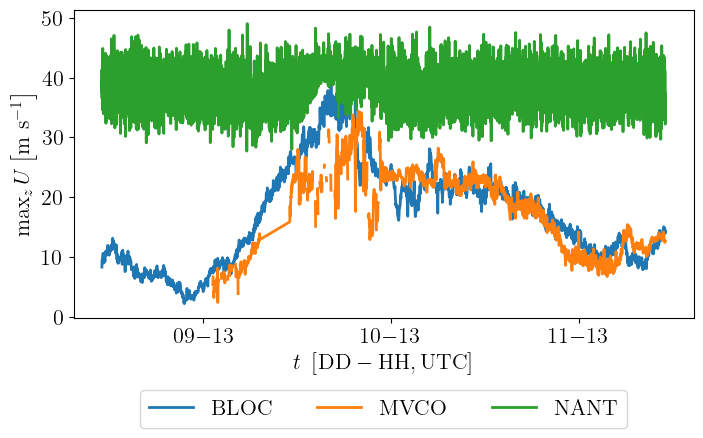

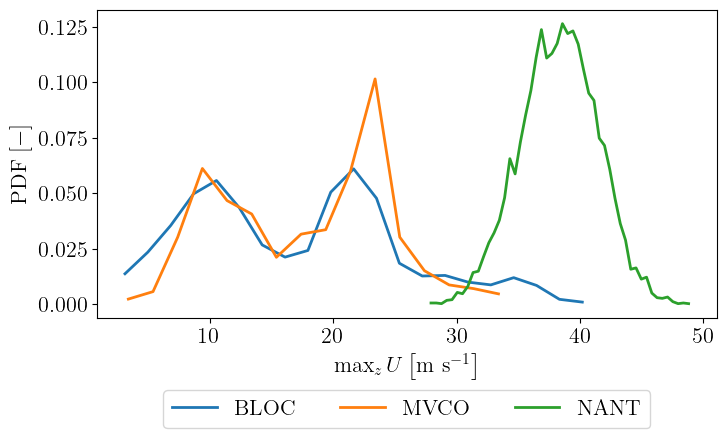

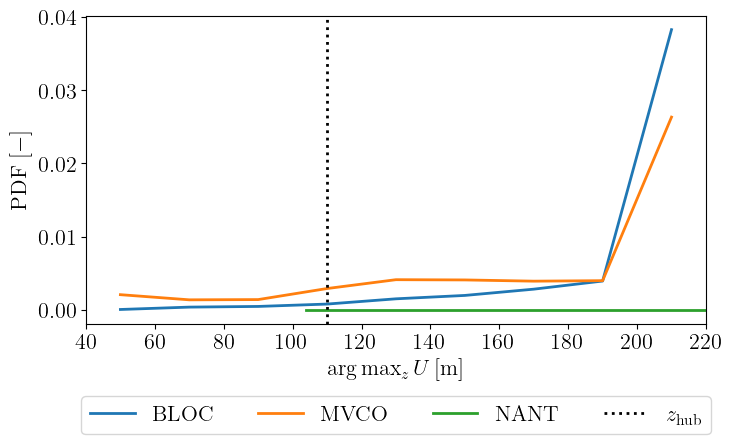

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(all_t_BLOC, all_maxWS_BLOC, linewidth=2, label="BLOC")
plt.plot(all_t_MVCO, all_maxWS_MVCO, linewidth=2, label="MVCO")
plt.plot(all_t_NANT, all_maxWS_NANT, linewidth=2, label="NANT")
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))            
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))        
plt.xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
plt.ylabel(r'$\max_z U \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3, frameon=True, fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.savefig("maxWS.png", dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(binCenters_maxWS_BLOC, PDF_maxWS_BLOC, lw=2, label="BLOC")
plt.plot(binCenters_maxWS_MVCO, PDF_maxWS_MVCO, lw=2, label="MVCO")
plt.plot(binCenters_maxWS_NANT, PDF_maxWS_NANT, lw=2, label="NANT")
plt.xlabel(r'$\max_z U \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
plt.ylabel(r'PDF $\left[-\right]$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)
plt.savefig("PDF_maxWS.png", dpi=600, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(binCenters_z_maxWS_BLOC, PDF_z_maxWS_BLOC, lw=2, label="BLOC")
plt.plot(binCenters_z_maxWS_MVCO, PDF_z_maxWS_MVCO, lw=2, label="MVCO")
plt.plot(binCenters_z_maxWS_NANT, PDF_z_maxWS_NANT, lw=2, label="NANT")
plt.axvline(z_hub, lw=2, ls=':', color='k', label=r"$z_{\mathrm{hub}}$")
plt.xlim(np.min([z_BLOC.min(), z_NANT.min()]), np.min([z_BLOC.max(), z_NANT.max()]))
plt.xlabel(r'$\arg \max_z U \left[\mathrm{m}\right]$', fontsize=16)
plt.ylabel(r'PDF $\left[-\right]$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=4)
plt.savefig("PDF_z_maxWS.png", dpi=600, bbox_inches="tight")
plt.show()


In [18]:
print(f"(BLOC) Maximum wind speed corresponding to maximum PDF: {maxPDF_binCenters_maxWS_BLOC:.1f} m/s")
print(f"(MVCO) Maximum wind speed corresponding to maximum PDF: {maxPDF_binCenters_maxWS_MVCO:.1f} m/s")
print(f"(NANT) Maximum wind speed corresponding to maximum PDF: {maxPDF_binCenters_maxWS_NANT:.1f} m/s")
print()

print(f"(BLOC) Height corresponding to maximum PDF of maximum wind speed: {maxPDF_binCenters_z_maxWS_BLOC:.1f} m/s")
print(f"(MVCO) Height corresponding to maximum PDF of maximum wind speed: {maxPDF_binCenters_z_maxWS_MVCO:.1f} m/s")
print(f"(NANT) Height corresponding to maximum PDF of maximum wind speed: {maxPDF_binCenters_z_maxWS_NANT:.1f} m/s")
print()


(BLOC) Maximum wind speed corresponding to maximum PDF: 21.7 m/s
(MVCO) Maximum wind speed corresponding to maximum PDF: 23.4 m/s
(NANT) Maximum wind speed corresponding to maximum PDF: 38.6 m/s

(BLOC) Height corresponding to maximum PDF of maximum wind speed: 210.0 m/s
(MVCO) Height corresponding to maximum PDF of maximum wind speed: 210.0 m/s
(NANT) Height corresponding to maximum PDF of maximum wind speed: 4962.3 m/s



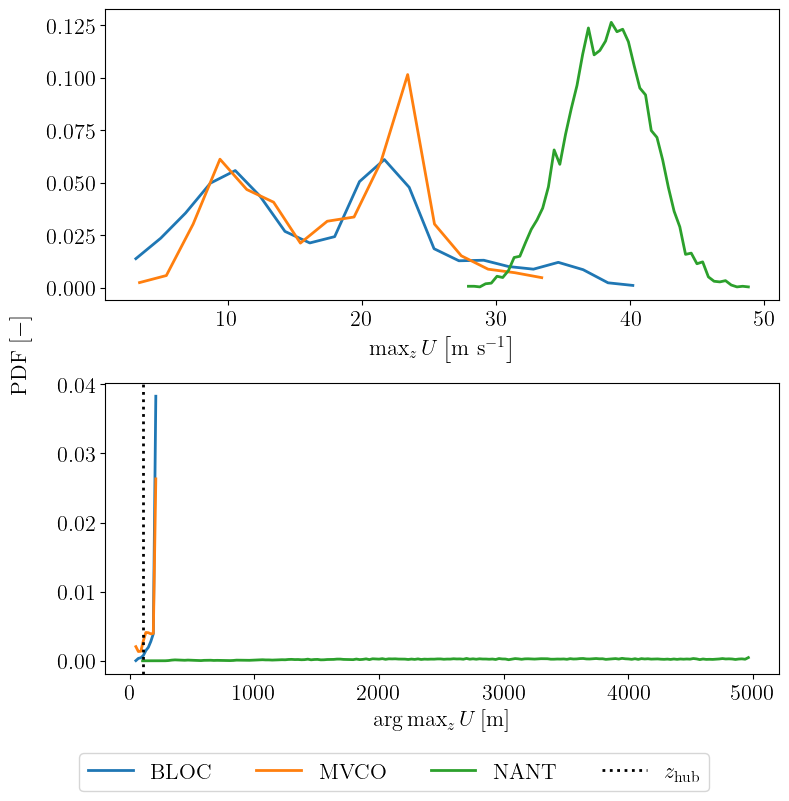

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8)) 

# ==========================
# (a) PDF of max wind speed
# ==========================
axs[0].plot(binCenters_maxWS_BLOC, PDF_maxWS_BLOC, lw=2, label="BLOC")
axs[0].plot(binCenters_maxWS_MVCO, PDF_maxWS_MVCO, lw=2, label="MVCO")
axs[0].plot(binCenters_maxWS_NANT, PDF_maxWS_NANT, lw=2, label="NANT")

axs[0].set_xlabel(r'$\max_z U \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
axs[0].tick_params(axis="both", labelsize=16)

# =======================
# (b) PDF of height of max wind speed
# =======================
axs[1].plot(binCenters_z_maxWS_BLOC, PDF_z_maxWS_BLOC, lw=2)
axs[1].plot(binCenters_z_maxWS_MVCO, PDF_z_maxWS_MVCO, lw=2)
axs[1].plot(binCenters_z_maxWS_NANT, PDF_z_maxWS_NANT, lw=2)

axs[1].axvline(z_hub, lw=2, ls=':', color='k', label=r"$z_{\mathrm{hub}}$")

#axs[1].set_xlim(np.min([z_BLOC.min(), z_NANT.min()]), np.min([z_BLOC.max(), z_NANT.max()]))

axs[1].set_xlabel(r'$\arg\max_z U \left[\mathrm{m}\right]$', fontsize=16)
axs[1].tick_params(axis="both", labelsize=16)

# =======================
# Shared y-axis label only
# =======================
fig.supylabel(r'PDF $\left[-\right]$', fontsize=16, y=0.55)

# =======================
# Shared legend
# =======================
handles, labels = axs[0].get_legend_handles_labels()
handles.append(axs[1].lines[-1])  # z_hub line
labels.append(r"$z_{\mathrm{hub}}$")

fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.01),
    ncol=4,
    frameon=True,
    fontsize=16
)

# =======================
# Layout + save
# =======================
fig.tight_layout(rect=[0, 0.06, 1, 1])
fig.savefig("PDF_maxWS_2x1.png", dpi=600, bbox_inches="tight")
plt.show()


In [20]:
# Define the averaging period in minutes for the rolling mean:
avg_period = 10

# Compute the uniform time-step sampling in minutes:
dt_BLOC_MVCO = (all_t_BLOC[1]-all_t_BLOC[0])*1440
dt_NANT      = (all_t_NANT[1]-all_t_NANT[0])*1440

# Compute the number of model time steps/samples in the rolling window:
window_size_BLOC_MVCO = int(round(avg_period/dt_BLOC_MVCO))
window_size_NANT      = int(round(avg_period/dt_NANT))

# Make a pandas Series indexed by time:
panda_all_BLOC = pd.DataFrame(all_WS_BLOC.T, index=all_t_BLOC)
panda_all_MVCO = pd.DataFrame(all_WS_MVCO.T, index=all_t_MVCO)
panda_all_NANT = pd.DataFrame(all_WS_NANT.T, index=all_t_NANT)
panda_hub_BLOC = pd.Series(all_WS_hub_BLOC,  index=all_t_BLOC)
panda_hub_MVCO = pd.Series(all_WS_hub_MVCO,  index=all_t_MVCO)
panda_hub_NANT = pd.Series(all_WS_hub_NANT,  index=all_t_NANT)

# Compute the centered rolling average of the wind speed at hub height:
WS_10min_avg_BLOC     = panda_all_BLOC.rolling(window=window_size_BLOC_MVCO, center=True, min_periods=1).mean().to_numpy()
WS_10min_avg_MVCO     = panda_all_MVCO.rolling(window=window_size_BLOC_MVCO, center=True, min_periods=1).mean().to_numpy()
WS_10min_avg_NANT     = panda_all_NANT.rolling(window=window_size_NANT,      center=True, min_periods=1).mean().to_numpy()
WS_10min_avg_hub_BLOC = panda_hub_BLOC.rolling(window=window_size_BLOC_MVCO, center=True, min_periods=1).mean().to_numpy()
WS_10min_avg_hub_MVCO = panda_hub_MVCO.rolling(window=window_size_BLOC_MVCO, center=True, min_periods=1).mean().to_numpy()
WS_10min_avg_hub_NANT = panda_hub_NANT.rolling(window=window_size_NANT,      center=True, min_periods=1).mean().to_numpy()


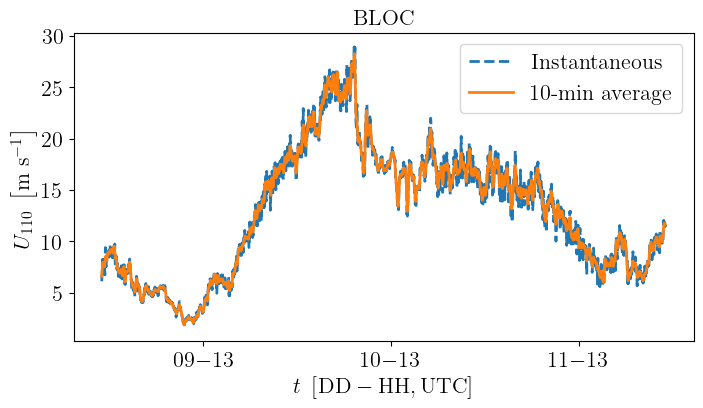

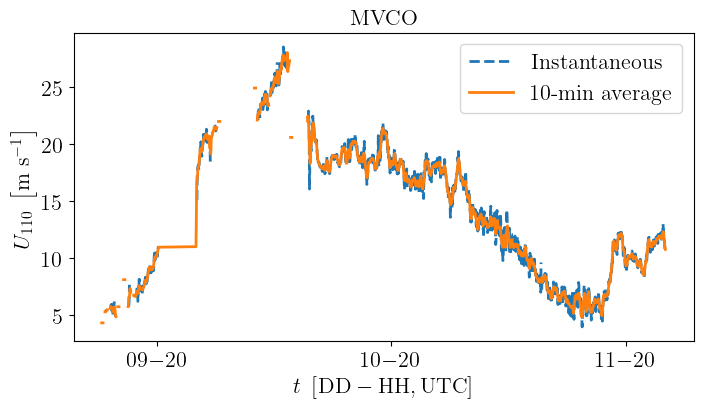

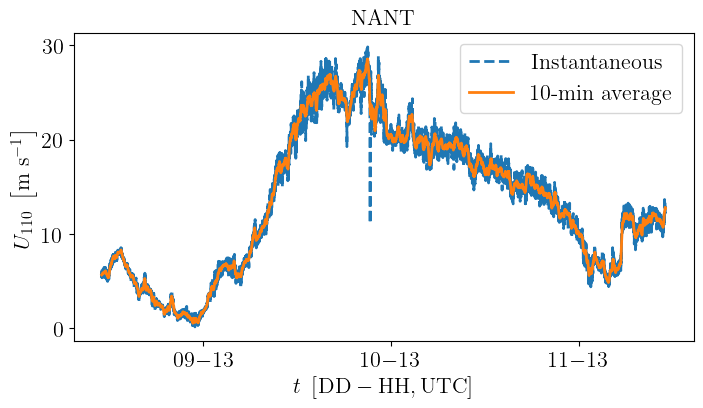

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(all_t_BLOC, all_WS_hub_BLOC,       lw=2, ls='--', label="Instantaneous")
plt.plot(all_t_BLOC, WS_10min_avg_hub_BLOC, lw=2, ls='-',  label="10-min average")
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))            
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))   
plt.xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
plt.ylabel(rf'$U_{{{z_hub:.0f}}}\ \left[\mathrm{{m\ s}}^{{-1}}\right]$', fontsize=16)
plt.title(r'BLOC', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.savefig("10min_avg_BLOC.png", dpi=600, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(all_t_MVCO, all_WS_hub_MVCO,       lw=2, ls='--', label="Instantaneous")
plt.plot(all_t_MVCO, WS_10min_avg_hub_MVCO, lw=2, ls='-',  label="10-min average")
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))            
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))   
plt.xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
plt.ylabel(rf'$U_{{{z_hub:.0f}}}\ \left[\mathrm{{m\ s}}^{{-1}}\right]$', fontsize=16)
plt.title(r"MVCO", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.savefig("10min_avg_MVCO.png", dpi=600, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(all_t_NANT, all_WS_hub_NANT,       lw=2, ls='--', label="Instantaneous")
plt.plot(all_t_NANT, WS_10min_avg_hub_NANT, lw=2, ls='-',  label="10-min average")
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))            
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))   
plt.xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
plt.ylabel(rf'$U_{{{z_hub:.0f}}}\ \left[\mathrm{{m\ s}}^{{-1}}\right]$', fontsize=16)
plt.title(r'NANT', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper right')
plt.savefig("10min_avg_NANT.png", dpi=600, bbox_inches="tight")
plt.show()


In [22]:
# Extract the height of each histogram bar and 
PDF_WS_10min_avg_hub_BLOC, binEdges_WS_10min_avg_hub_BLOC = np.histogram(WS_10min_avg_hub_BLOC[~np.isnan(WS_10min_avg_hub_BLOC)], bins='auto', density=True)
PDF_WS_10min_avg_hub_MVCO, binEdges_WS_10min_avg_hub_MVCO = np.histogram(WS_10min_avg_hub_MVCO[~np.isnan(WS_10min_avg_hub_MVCO)], bins='auto', density=True)
PDF_WS_10min_avg_hub_NANT, binEdges_WS_10min_avg_hub_NANT = np.histogram(WS_10min_avg_hub_NANT[~np.isnan(WS_10min_avg_hub_NANT)], bins='auto', density=True)

# Get the index of maximum PDF:
index_maxPDF_WS_10min_avg_hub_BLOC = np.argmax(PDF_WS_10min_avg_hub_BLOC)
index_maxPDF_WS_10min_avg_hub_MVCO = np.argmax(PDF_WS_10min_avg_hub_MVCO)
index_maxPDF_WS_10min_avg_hub_NANT = np.argmax(PDF_WS_10min_avg_hub_NANT)

# Get the bin centers:
binCenters_WS_10min_avg_hub_BLOC = 0.5 * (binEdges_WS_10min_avg_hub_BLOC[1:]+binEdges_WS_10min_avg_hub_BLOC[:-1])
binCenters_WS_10min_avg_hub_MVCO = 0.5 * (binEdges_WS_10min_avg_hub_MVCO[1:]+binEdges_WS_10min_avg_hub_MVCO[:-1])
binCenters_WS_10min_avg_hub_NANT = 0.5 * (binEdges_WS_10min_avg_hub_NANT[1:]+binEdges_WS_10min_avg_hub_NANT[:-1])

# Get the bin center at maximum PDF:
maxPDF_binCenters_WS_10min_avg_hub_BLOC = binCenters_WS_10min_avg_hub_BLOC[index_maxPDF_WS_10min_avg_hub_BLOC]
maxPDF_binCenters_WS_10min_avg_hub_MVCO = binCenters_WS_10min_avg_hub_MVCO[index_maxPDF_WS_10min_avg_hub_MVCO]
maxPDF_binCenters_WS_10min_avg_hub_NANT = binCenters_WS_10min_avg_hub_NANT[index_maxPDF_WS_10min_avg_hub_NANT]


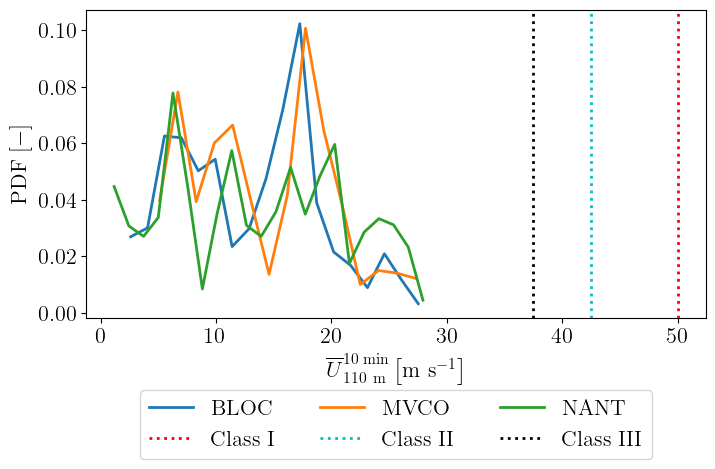

In [23]:
# Define the reference wind speeds for different classes of WTs in meters per second:
U_ref_10min_classI   = 50
U_ref_10min_classII  = 42.5
U_ref_10min_classIII = 37.5

plt.figure(figsize=(8, 4))
plt.plot(binCenters_WS_10min_avg_hub_BLOC, PDF_WS_10min_avg_hub_BLOC, lw=2, label="BLOC")
plt.axvline(U_ref_10min_classI,   lw=2, ls=':', color='r', label="Class I")
plt.plot(binCenters_WS_10min_avg_hub_MVCO, PDF_WS_10min_avg_hub_MVCO, lw=2, label="MVCO")
plt.axvline(U_ref_10min_classII,  lw=2, ls=':', color='c', label="Class II")
plt.plot(binCenters_WS_10min_avg_hub_NANT, PDF_WS_10min_avg_hub_NANT, lw=2, label="NANT")
plt.axvline(U_ref_10min_classIII, lw=2, ls=':', color='k', label="Class III")
plt.xlabel(r'$\overline{U}_{110\ \mathrm{m}}^{\mathrm{10\ \! min}} \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
plt.ylabel(r'PDF $\left[-\right]$', fontsize=16)
#plt.title(rf'$z = {z_hub}\ \mathrm{{m}}$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)
plt.savefig("PDF_WS_10min_avg_hub.png", dpi=600, bbox_inches="tight")
plt.show()


In [24]:
print(f"(BLOC) Speed corresponding to maximum PDF of maximum wind speed averaged over 10 minutes: {maxPDF_binCenters_WS_10min_avg_hub_BLOC:.1f} m/s")
print(f"(MVCO) Speed corresponding to maximum PDF of maximum wind speed averaged over 10 minutes: {maxPDF_binCenters_WS_10min_avg_hub_MVCO:.1f} m/s")
print(f"(NANT) Speed corresponding to maximum PDF of maximum wind speed averaged over 10 minutes: {maxPDF_binCenters_WS_10min_avg_hub_NANT:.1f} m/s")
print()


(BLOC) Speed corresponding to maximum PDF of maximum wind speed averaged over 10 minutes: 17.3 m/s
(MVCO) Speed corresponding to maximum PDF of maximum wind speed averaged over 10 minutes: 17.8 m/s
(NANT) Speed corresponding to maximum PDF of maximum wind speed averaged over 10 minutes: 6.3 m/s



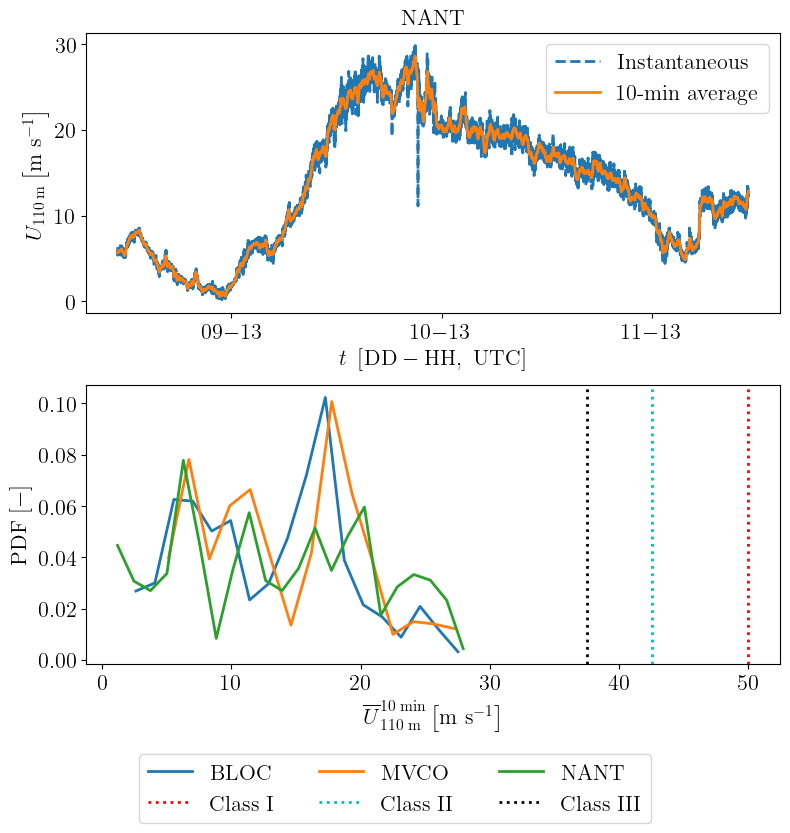

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=False)

# =======================
# (a) NANT time series
# =======================
axs[0].plot(all_t_NANT, all_WS_hub_NANT,       lw=2, ls='--', label="Instantaneous")
axs[0].plot(all_t_NANT, WS_10min_avg_hub_NANT, lw=2, ls='-',  label="10-min average")

axs[0].xaxis_date()
axs[0].xaxis.set_major_locator(mdates.HourLocator(interval=24))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))

axs[0].set_xlabel(r'$t\ \left[\mathrm{DD-HH,\ UTC}\right]$', fontsize=16)
axs[0].set_ylabel(rf'$U_{{{z_hub:.0f}\ \! \mathrm{{m}}}} \left[\mathrm{{m\ s}}^{{-1}}\right]$', fontsize=16)
axs[0].set_title(r'NANT', fontsize=16)

axs[0].tick_params(axis="both", labelsize=16)
axs[0].legend(fontsize=16, loc='upper right')

# =======================
# (b) PDF of 10-min averaged wind speed
# =======================
axs[1].plot(binCenters_WS_10min_avg_hub_BLOC, PDF_WS_10min_avg_hub_BLOC, lw=2, label="BLOC")
axs[1].axvline(U_ref_10min_classI, lw=2, ls=':', color='r', label="Class I")

axs[1].plot(binCenters_WS_10min_avg_hub_MVCO, PDF_WS_10min_avg_hub_MVCO, lw=2, label="MVCO")
axs[1].axvline(U_ref_10min_classII, lw=2, ls=':', color='c', label="Class II")

axs[1].plot(binCenters_WS_10min_avg_hub_NANT, PDF_WS_10min_avg_hub_NANT, lw=2, label="NANT")
axs[1].axvline(U_ref_10min_classIII, lw=2, ls=':', color='k', label="Class III")

axs[1].set_xlabel( r'$\overline{U}_{110\ \! \mathrm{m}}^{\mathrm{10\ \! min}} \left[\mathrm{m\ s}^{-1}\right]$', fontsize=16)
axs[1].set_ylabel(r'PDF $\left[-\right]$', fontsize=16)
#axs[1].set_title(rf'$z = {z_hub}\ \mathrm{{m}}$', fontsize=16)

axs[1].tick_params(axis="both", labelsize=16)

# =======================
# Shared legend (bottom panel semantics)
# =======================
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    frameon=True,
    fontsize=16
)

# =======================
# Layout + save
# =======================
fig.tight_layout(rect=[0, 0.06, 1, 1])
fig.savefig("10min_avg_NANT_2x1.png", dpi=600, bbox_inches="tight")
plt.show()


In [26]:
# Compute the shear exponent:
alpha_10min_BLOC = np.log(WS_10min_avg_BLOC/WS_10min_avg_hub_BLOC[:, None])/np.log(z_BLOC/z_hub)
alpha_10min_MVCO = np.log(WS_10min_avg_MVCO/WS_10min_avg_hub_MVCO[:, None])/np.log(z_MVCO/z_hub)
alpha_10min_NANT = np.log(WS_10min_avg_NANT/WS_10min_avg_hub_NANT[:, None])/np.log(z_NANT/z_hub)

# Define a boolean mask for the hub height:
hub_col_BLOC = np.isclose(z_BLOC, z_hub)         
hub_col_MVCO = np.isclose(z_MVCO, z_hub)
hub_col_NANT = np.isclose(z_NANT, z_hub)

# Replace the 0 values of the shear exponent with NaNs at the hub height:
alpha_10min_BLOC[:, hub_col_BLOC] = np.nan
alpha_10min_MVCO[:, hub_col_MVCO] = np.nan
alpha_10min_NANT[:, hub_col_NANT] = np.nan

# Define the reference shear exponent:
alpha_ref = 0.11


In [27]:
# Extract the height of each histogram bar and 
PDF_alpha_10min_BLOC, binEdges_alpha_10min_BLOC = np.histogram(alpha_10min_BLOC[~np.isnan(alpha_10min_BLOC)].flatten(), bins='auto', density=True)
PDF_alpha_10min_MVCO, binEdges_alpha_10min_MVCO = np.histogram(alpha_10min_MVCO[~np.isnan(alpha_10min_MVCO)].flatten(), bins='auto', density=True)
PDF_alpha_10min_NANT, binEdges_alpha_10min_NANT = np.histogram(alpha_10min_NANT[~np.isnan(alpha_10min_NANT)].flatten(), bins='auto', density=True)

# Get the index of maximum PDF:
index_maxPDF_alpha_10min_BLOC = np.argmax(PDF_alpha_10min_BLOC)
index_maxPDF_alpha_10min_MVCO = np.argmax(PDF_alpha_10min_MVCO)
index_maxPDF_alpha_10min_NANT = np.argmax(PDF_alpha_10min_NANT)

# Get the bin centers:
binCenters_alpha_10min_BLOC = 0.5 * (binEdges_alpha_10min_BLOC[1:]+binEdges_alpha_10min_BLOC[:-1])
binCenters_alpha_10min_MVCO = 0.5 * (binEdges_alpha_10min_MVCO[1:]+binEdges_alpha_10min_MVCO[:-1])
binCenters_alpha_10min_NANT = 0.5 * (binEdges_alpha_10min_NANT[1:]+binEdges_alpha_10min_NANT[:-1])

# Get the bin center at maximum PDF:
maxPDF_binCenters_alpha_10min_BLOC = binCenters_alpha_10min_BLOC[index_maxPDF_alpha_10min_BLOC]
maxPDF_binCenters_alpha_10min_MVCO = binCenters_alpha_10min_MVCO[index_maxPDF_alpha_10min_MVCO]
maxPDF_binCenters_alpha_10min_NANT = binCenters_alpha_10min_NANT[index_maxPDF_alpha_10min_NANT]


In [87]:
print(f"(BLOC) Alpha corresponding to maximum PDF of alpha: {maxPDF_binCenters_alpha_10min_BLOC:.2f} m/s")
print(f"(MVCO) Alpha corresponding to maximum PDF of alpha: {maxPDF_binCenters_alpha_10min_MVCO:.2f} m/s")
print(f"(NANT) Alpha corresponding to maximum PDF of alpha: {maxPDF_binCenters_alpha_10min_NANT:.2f} m/s")
print()


(BLOC) Alpha corresponding to maximum PDF of alpha: 0.14 m/s
(MVCO) Alpha corresponding to maximum PDF of alpha: 0.31 m/s
(NANT) Alpha corresponding to maximum PDF of alpha: -0.00 m/s



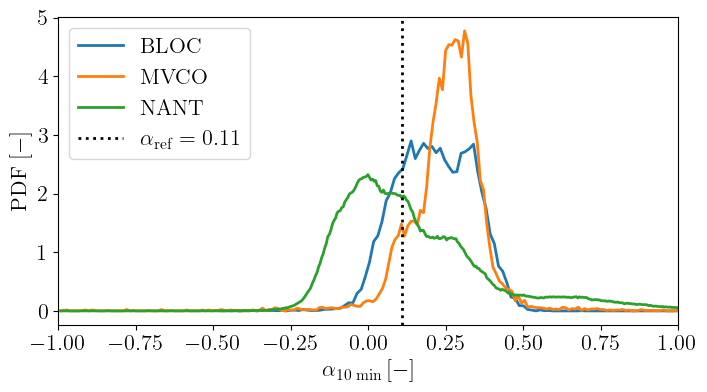

In [28]:
plt.figure(figsize=(8, 4))
plt.plot(binCenters_alpha_10min_BLOC, PDF_alpha_10min_BLOC, lw=2, label="BLOC")
plt.plot(binCenters_alpha_10min_MVCO, PDF_alpha_10min_MVCO, lw=2, label="MVCO")
plt.plot(binCenters_alpha_10min_NANT, PDF_alpha_10min_NANT, lw=2, label="NANT")
plt.axvline(alpha_ref, lw=2, ls=':', color='k', label=r"$\alpha_{\mathrm{ref}}=0.11$")
plt.xlim(-1, 1)
plt.xlabel(r'$\alpha_{\mathrm{10\ \! min}} \left[-\right]$', fontsize=16)
plt.ylabel(r'PDF $\left[-\right]$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper left')
plt.savefig("PDF_alpha_10min.png", dpi=600, bbox_inches="tight")
plt.show()


In [30]:
# Define the reference turbulence intensities corresponding to different WT classes:
TI_classAPLUS = 0.18
TI_classA     = 0.16
TI_classB     = 0.14
TI_classC     = 0.12

# Define the period over which TI is calculated:
T = 10        
# Define the number of sample points in the window:
N_BLOC = int(T/dt_BLOC_MVCO)   
N_NANT = int(T/dt_NANT)    

def compute_TI(WS, N):
    # Compute the number of 10-min blocks:
    n_blocks = len(WS)//N
    # Reshape the speed array:
    WS = WS[:n_blocks*N].reshape(n_blocks, N)
    
    # Compute the mean: 
    mu = np.nanmean(WS, axis=1)  
    # Compute the standard deviation:
    sigma = np.nanstd(WS, axis=1, ddof=1)       
    # Compute the turbulence intensity:
    TI = sigma/mu       
    
    return mu, sigma, TI

_, _, TI_BLOC_10min = compute_TI(WS_hub_BLOC, N_BLOC)
_, _, TI_MVCO_10min = compute_TI(WS_hub_MVCO, N_BLOC)
_, _, TI_NANT_10min = compute_TI(WS_hub_NANT, N_NANT)

# Summaries:
print(f"Mean 10-min TI at BLOC: {np.nanmean(TI_BLOC_10min):.3f}")
print(f"Mean 10-min TI at MVCO: {np.nanmean(TI_MVCO_10min):.3f}")
print(f"Mean 10-min TI at NANT: {np.nanmean(TI_NANT_10min):.3f}")
print()


Mean 10-min TI at BLOC: 0.057
Mean 10-min TI at MVCO: 0.046
Mean 10-min TI at NANT: 0.052



(BLOC) TI corresponding to maximum PDF of TI: 0.052
(MVCO) TI corresponding to maximum PDF of TI: 0.024
(NANT) TI corresponding to maximum PDF of TI: 0.038



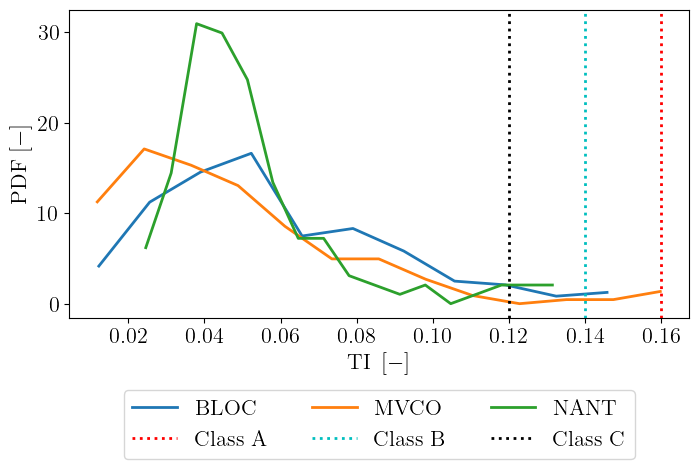

In [31]:
# Extract the height of each histogram bar and 
PDF_TI_BLOC, binEdges_TI_BLOC = np.histogram(TI_BLOC_10min, bins='auto', density=True)
PDF_TI_MVCO, binEdges_TI_MVCO = np.histogram(TI_MVCO_10min, bins='auto', density=True)
PDF_TI_NANT, binEdges_TI_NANT = np.histogram(TI_NANT_10min, bins='auto', density=True)

# Get the index of maximum PDF:
index_maxPDF_TI_BLOC = np.argmax(PDF_TI_BLOC)
index_maxPDF_TI_MVCO = np.argmax(PDF_TI_MVCO)
index_maxPDF_TI_NANT = np.argmax(PDF_TI_NANT)

# Get the bin centers:
binCenters_TI_BLOC = 0.5 * (binEdges_TI_BLOC[1:]+binEdges_TI_BLOC[:-1])
binCenters_TI_MVCO = 0.5 * (binEdges_TI_MVCO[1:]+binEdges_TI_MVCO[:-1])
binCenters_TI_NANT = 0.5 * (binEdges_TI_NANT[1:]+binEdges_TI_NANT[:-1])

# Get the bin center at maximum PDF:
maxPDF_binCenters_TI_BLOC = binCenters_TI_BLOC[index_maxPDF_TI_BLOC]
maxPDF_binCenters_TI_MVCO = binCenters_TI_MVCO[index_maxPDF_TI_MVCO]
maxPDF_binCenters_TI_NANT = binCenters_TI_NANT[index_maxPDF_TI_NANT]

print(f"(BLOC) TI corresponding to maximum PDF of TI: {maxPDF_binCenters_TI_BLOC:.3f}")
print(f"(MVCO) TI corresponding to maximum PDF of TI: {maxPDF_binCenters_TI_MVCO:.3f}")
print(f"(NANT) TI corresponding to maximum PDF of TI: {maxPDF_binCenters_TI_NANT:.3f}")
print()

plt.figure(figsize=(8, 4))
plt.plot(binCenters_TI_BLOC, PDF_TI_BLOC, lw=2, label="BLOC")
plt.axvline(TI_classA, lw=2, ls=':', color='r', label="Class A")
plt.plot(binCenters_TI_MVCO, PDF_TI_MVCO, lw=2, label="MVCO")
plt.axvline(TI_classB, lw=2, ls=':', color='c', label="Class B")
plt.plot(binCenters_TI_NANT, PDF_TI_NANT, lw=2, label="NANT")
plt.axvline(TI_classC, lw=2, ls=':', color='k', label="Class C")
#plt.xlim(-0.25, 0.25)
plt.xlabel(r'$\mathrm{TI}\ \left[-\right]$', fontsize=16)
plt.ylabel(r'PDF $\left[-\right]$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)
plt.savefig("PDF_TI_10min.png", dpi=600, bbox_inches="tight")
plt.show()


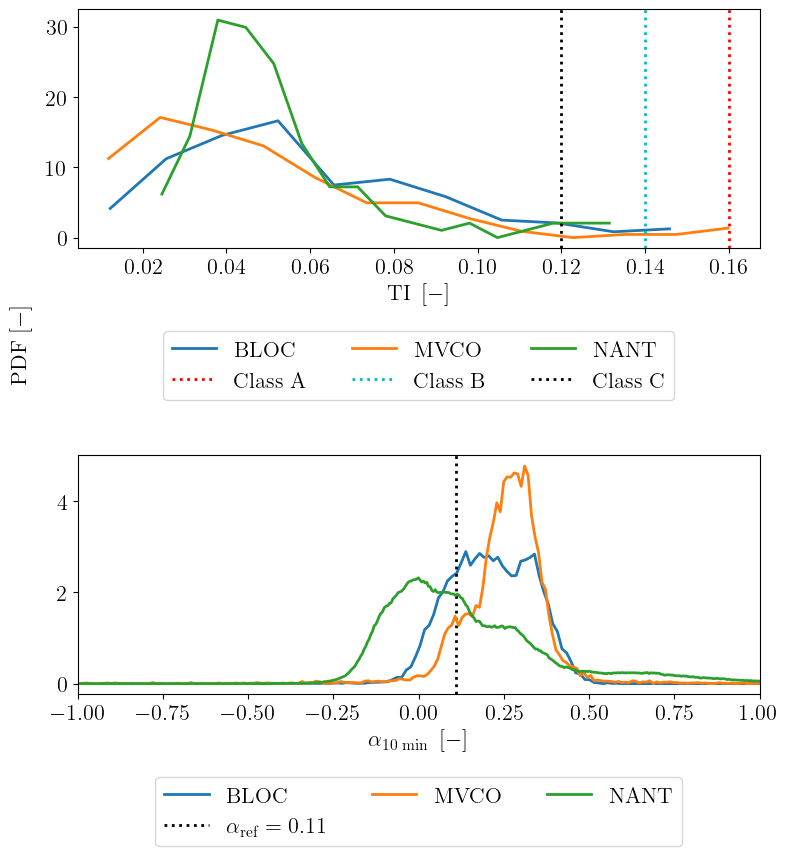

In [32]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=False)

# =======================
# (a) PDF of 10-min turbulence intensity
# =======================
axs[0].plot(binCenters_TI_BLOC, PDF_TI_BLOC, lw=2, label="BLOC")
axs[0].axvline(TI_classA, lw=2, ls=':', color='r', label="Class A")

axs[0].plot(binCenters_TI_MVCO, PDF_TI_MVCO, lw=2, label="MVCO")
axs[0].axvline(TI_classB, lw=2, ls=':', color='c', label="Class B")

axs[0].plot(binCenters_TI_NANT, PDF_TI_NANT, lw=2, label="NANT")
axs[0].axvline(TI_classC, lw=2, ls=':', color='k', label="Class C")

axs[0].set_xlabel(r'$\mathrm{TI}\ \left[-\right]$', fontsize=16)
#axs[0].set_ylabel(r'PDF $\left[-\right]$', fontsize=16)
axs[0].tick_params(axis="both", labelsize=16)

axs[0].legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=3)

# =======================
# (b) PDF of 10-min shear exponent
# =======================
axs[1].plot(binCenters_alpha_10min_BLOC, PDF_alpha_10min_BLOC, lw=2, label="BLOC")
axs[1].axvline(alpha_ref, lw=2, ls=':', color='k', label=r"$\alpha_{\mathrm{ref}}=0.11$")

axs[1].plot(binCenters_alpha_10min_MVCO, PDF_alpha_10min_MVCO, lw=2, label="MVCO")
axs[1].plot(binCenters_alpha_10min_NANT, PDF_alpha_10min_NANT, lw=2, label="NANT")

axs[1].set_xlim(-1, 1)
axs[1].set_xlabel(r'$\alpha_{\mathrm{10\ \! min}}\ \left[-\right]$', fontsize=16)
#axs[1].set_ylabel(r'PDF $\left[-\right]$', fontsize=16)
axs[1].tick_params(axis="both", labelsize=16)

axs[1].legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=3)

fig.supylabel(r'PDF $\left[-\right]$', fontsize=16, y=0.65)

# =======================
# Layout + save
# =======================
fig.tight_layout(rect=[0, 0.10, 1, 1])
fig.savefig("PDF_TI_alpha_10min_2x1.png", dpi=600, bbox_inches="tight")
plt.show()


In [34]:
# Compute wind veer over height:
veer_BLOC = (np.diff(all_WD_BLOC, axis=0)+180)%360-180  
veer_MVCO = (np.diff(all_WD_MVCO, axis=0)+180)%360-180   
veer_NANT = (np.diff(all_WD_NANT, axis=0)+180)%360-180   

# Compute the vertical spacing:
dz_BLOC_MVCO = np.diff(z_BLOC)
dz_NANT      = np.diff(z_NANT)

# Compute the veer slope:
veer_rate_BLOC = veer_BLOC/dz_BLOC_MVCO[:, None]
veer_rate_MVCO = veer_MVCO/dz_BLOC_MVCO[:, None]
veer_rate_NANT = veer_NANT/dz_NANT[:, None] 


In [35]:
# Extract the height of each histogram bar and 
PDF_veer_BLOC, binEdges_veer_BLOC = np.histogram(veer_rate_BLOC[~np.isnan(veer_rate_BLOC)].flatten(), bins='auto', density=True)
PDF_veer_MVCO, binEdges_veer_MVCO = np.histogram(veer_rate_MVCO[~np.isnan(veer_rate_MVCO)].flatten(), bins='auto', density=True)
PDF_veer_NANT, binEdges_veer_NANT = np.histogram(veer_rate_NANT, bins='auto', density=True)

# Get the index of maximum PDF:
index_maxPDF_veer_BLOC = np.argmax(PDF_veer_BLOC)
index_maxPDF_veer_MVCO = np.argmax(PDF_veer_MVCO)
index_maxPDF_veer_NANT = np.argmax(PDF_veer_NANT)

# Get the bin centers:
binCenters_veer_BLOC = 0.5 * (binEdges_veer_BLOC[1:]+binEdges_veer_BLOC[:-1])
binCenters_veer_MVCO = 0.5 * (binEdges_veer_MVCO[1:]+binEdges_veer_MVCO[:-1])
binCenters_veer_NANT = 0.5 * (binEdges_veer_NANT[1:]+binEdges_veer_NANT[:-1])

# Get the bin center at maximum PDF:
maxPDF_binCenters_veer_BLOC = binCenters_veer_BLOC[index_maxPDF_veer_BLOC]
maxPDF_binCenters_veer_MVCO = binCenters_veer_MVCO[index_maxPDF_veer_MVCO]
maxPDF_binCenters_veer_NANT = binCenters_veer_NANT[index_maxPDF_veer_NANT]


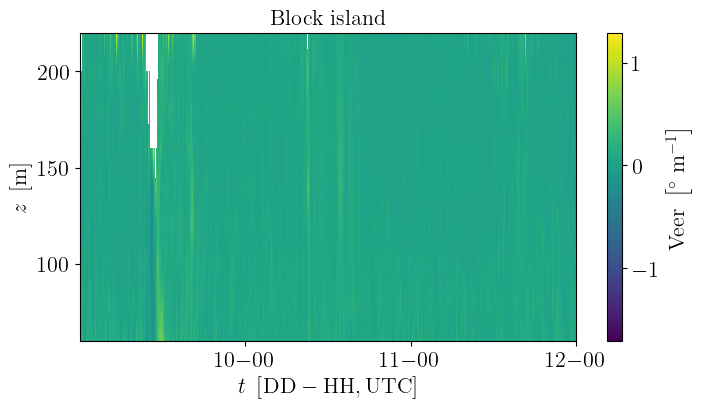

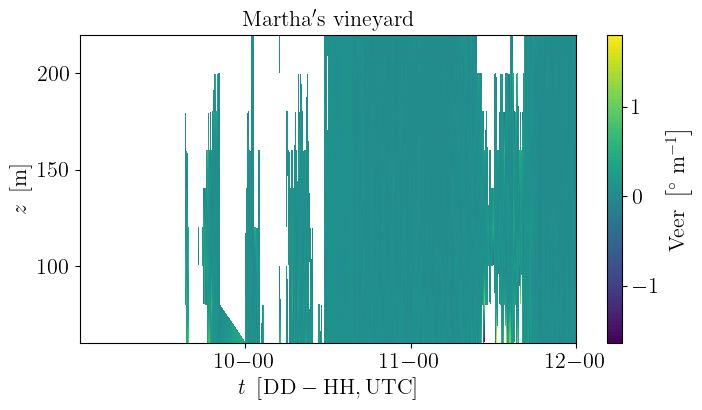

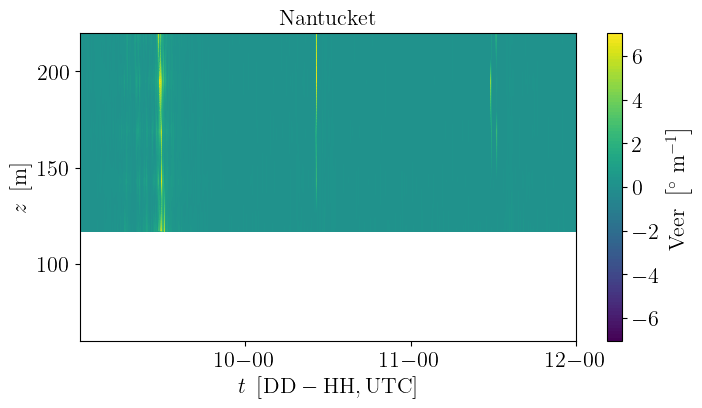

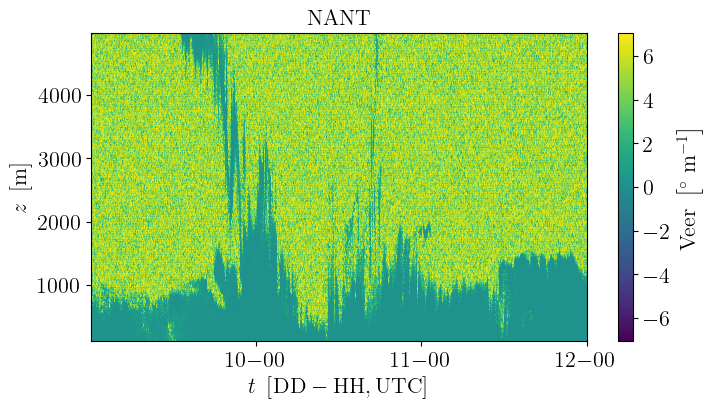

In [36]:
plt.figure(figsize=(8, 4))
cp = plt.contourf(all_t_BLOC, z_BLOC[1:], veer_rate_BLOC, levels=100, cmap='viridis')
cbar = plt.colorbar(cp)
cbar.set_label(r'$\mathrm{Veer}\ \left[^\circ\ \mathrm{m}^{-1}\right]$', fontsize=16)
cbar.ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
cbar.ax.tick_params(labelsize=16)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))           
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))        
plt.xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
plt.ylabel(r'$z\ \left[\mathrm{m}\right]$', fontsize=16)
plt.title(r'$\mathrm{Block\ island}$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.savefig("veer_BLOC.png", dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
cp = plt.contourf(all_t_MVCO, z_MVCO[1:], veer_rate_MVCO, levels=100, cmap='viridis')
cbar = plt.colorbar(cp)
cbar.set_label(r'$\mathrm{Veer}\ \left[^\circ\ \mathrm{m}^{-1}\right]$', fontsize=16)
cbar.ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
cbar.ax.tick_params(labelsize=16)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))           
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))        
plt.xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
plt.ylabel(r'$z\ \left[\mathrm{m}\right]$', fontsize=16)
plt.title(r"$\mathrm{Martha's\ vineyard}$", fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.savefig("veer_MVCO.png", dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
cp = plt.contourf(all_t_NANT, z_NANT[1:], veer_rate_NANT, levels=100, cmap='viridis')
cbar = plt.colorbar(cp)
cbar.set_label(r'$\mathrm{Veer}\ \left[^\circ\ \mathrm{m}^{-1}\right]$', fontsize=16)
cbar.ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
cbar.ax.tick_params(labelsize=16)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))           
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))        
plt.xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
plt.ylabel(r'$z\ \left[\mathrm{m}\right]$', fontsize=16)
plt.ylim(z_MVCO[1], z_MVCO[-1])
plt.title(r'$\mathrm{Nantucket}$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.savefig("veer_ylim_NANT.png", dpi=600, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 4))
cp = plt.contourf(all_t_NANT, z_NANT[1:], veer_rate_NANT, levels=100, cmap='viridis')
cbar = plt.colorbar(cp)
cbar.set_label(r'$\mathrm{Veer}\ \left[^\circ\ \mathrm{m}^{-1}\right]$', fontsize=16)
cbar.ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
cbar.ax.tick_params(labelsize=16)
ax = plt.gca()
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))           
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))        
plt.xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
plt.ylabel(r'$z\ \left[\mathrm{m}\right]$', fontsize=16)
plt.title(r'$\mathrm{NANT}$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.savefig("veer_NANT.png", dpi=600, bbox_inches='tight')
plt.show()


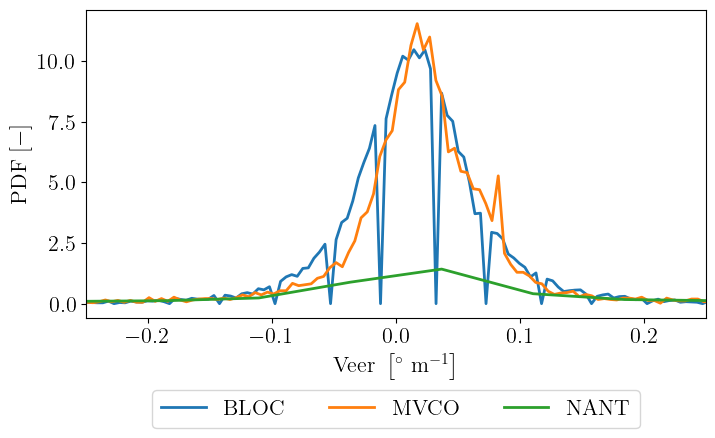

In [37]:
plt.figure(figsize=(8, 4))
plt.plot(binCenters_veer_BLOC, PDF_veer_BLOC, lw=2, label="BLOC")
plt.plot(binCenters_veer_MVCO, PDF_veer_MVCO, lw=2, label="MVCO")
plt.plot(binCenters_veer_NANT, PDF_veer_NANT, lw=2, label="NANT")
plt.xlim(-0.25, 0.25)
plt.xlabel(r'$\mathrm{Veer}\ \left[^\circ\ \mathrm{m}^{-1}\right]$', fontsize=16)
plt.ylabel(r'PDF $\left[-\right]$', fontsize=16)
plt.tick_params(axis="both", labelsize=16)
plt.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)
plt.savefig("PDF_veer_10min.png", dpi=600, bbox_inches="tight")
plt.show()


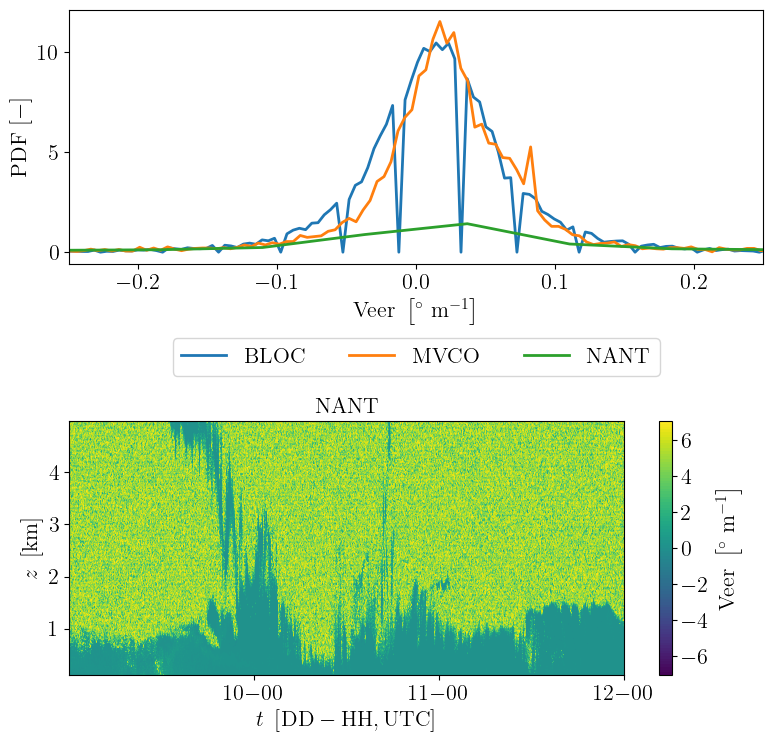

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=False)

# =======================
# (a) PDF of veer
# =======================
axs[0].plot(binCenters_veer_BLOC, PDF_veer_BLOC, lw=2, label="BLOC")
axs[0].plot(binCenters_veer_MVCO, PDF_veer_MVCO, lw=2, label="MVCO")
axs[0].plot(binCenters_veer_NANT, PDF_veer_NANT, lw=2, label="NANT")

axs[0].set_xlim(-0.25, 0.25)
axs[0].set_xlabel(r'$\mathrm{Veer}\ \left[^\circ\ \mathrm{m}^{-1}\right]$', fontsize=16)
axs[0].set_ylabel(r'PDF $\left[-\right]$', fontsize=16)
axs[0].tick_params(axis="both", labelsize=16)

axs[0].legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),
    ncol=3
)

# ===============================
# (b) Veer contour plot for NANT
# ===============================
cp = axs[1].contourf(all_t_NANT, z_NANT[1:]/1000, veer_rate_NANT, levels=100, cmap='viridis')

cbar = fig.colorbar(cp, ax=axs[1])
cbar.set_label(r'$\mathrm{Veer}\ \left[^\circ\ \mathrm{m}^{-1}\right]$', fontsize=16)
cbar.ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
cbar.ax.tick_params(labelsize=16)

axs[1].xaxis_date()
axs[1].xaxis.set_major_locator(mdates.HourLocator(interval=24))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d-%H'))

axs[1].set_xlabel(r'$t\ \left[\mathrm{DD-HH, UTC}\right]$', fontsize=16)
axs[1].set_ylabel(r'$z\ \left[\mathrm{km}\right]$', fontsize=16)
axs[1].set_title(r'$\mathrm{NANT}$', fontsize=16)
axs[1].tick_params(axis="both", labelsize=16)

# ==============
# Layout + save
# ==============
fig.tight_layout(rect=[0, 0.06, 1, 1])  # leave room for top legend
fig.savefig("veer_2x1.png", dpi=600, bbox_inches="tight")
plt.show()


In [94]:
print(f"(BLOC) Veer corresponding to maximum PDF of veer: {maxPDF_binCenters_veer_BLOC:.3f}")
print(f"(MVCO) Veer corresponding to maximum PDF of veer: {maxPDF_binCenters_veer_MVCO:.3f}")
print(f"(NANT) Veer corresponding to maximum PDF of veer: {maxPDF_binCenters_veer_NANT:.3f}")
print()

(BLOC) Veer corresponding to maximum PDF of veer: 0.014
(MVCO) Veer corresponding to maximum PDF of veer: 0.017
(NANT) Veer corresponding to maximum PDF of veer: 0.037

